In [62]:
import pandas as pd
seed = 12
df = pd.read_excel('data/raw/new_clean_data_all.xlsx')
print(len(df))
print(df.columns)

46588
Index(['Unnamed: 0', 'No.', 'TextID', 'Title', 'Sentence', '無標註', '自殺與憂鬱',
       '無助或無望', '正向文字', '其他負向文字', '生理反應或醫療狀況', '自殺行為', '其他類型'],
      dtype='object')


In [63]:
other_type = []
for idx, row in df.iterrows():
    if row['無助或無望'] or row['其他負向文字'] or row['生理反應或醫療狀況']:
        other_type.append(1)
    else:
        other_type.append(0)
        if row['正向文字']:
            df['無標註'][idx] = 1
df['其他類型'] = other_type

/tmp/ipykernel_1131493/2306923281.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['無標註'][idx] = 1


In [64]:
df.to_excel("data/raw/four_class_1108.xlsx")

In [65]:
df = pd.read_excel('data/raw/four_class_1108.xlsx')
target_columns = ['TextID' , 'Title' ,'Sentence','無標註','自殺與憂鬱','自殺行為','其他類型']
df = df[target_columns]
all_labelize_df = []
new_column=['無標註','自殺與憂鬱','自殺行為','其他類型']
for label in new_column:
    all_labelize_df.append(df[df[label] == 1].loc[:])
for i in all_labelize_df:
    print(len(i))

34808
3443
139
8198


In [66]:
### new block at 11/13!!! Goal: take A2 sentence into training data
df_A2 = pd.read_excel('data/article/split_output_A2_v2_answer.xlsx')
df_A2 = df_A2[target_columns]
# DF = pd.concat([df, df_A2], axis=0, ignore_index=True)
all_labelize_df_A2 = []
for label in new_column:
    all_labelize_df_A2.append(df_A2[df_A2[label] == 1].loc[:])
for i in all_labelize_df_A2:
    print(len(i))


29460
4431
133
9844


In [67]:
# TODO: split "all_labelize_df" into "test_labelize_df" and "labelize_df"
# random_state = 1
test_labelize_df = []
labelize_df = []
for idx, a_df in enumerate(all_labelize_df):
    n0 = 40
    if idx == 0:
        n0 = 35
    elif idx == 1:
        n0 = 35
    elif idx == 2:
        n0 = 35
    else:
        n0 = 35
    test_labelize_df.append(a_df.sample(n=n0, random_state=seed))
    labelize_df.append(a_df.drop(test_labelize_df[-1].index))
for i in test_labelize_df:
    print(len(i))
for i in labelize_df:
    print(len(i))


35
35
35
35
34773
3408
104
8163


In [68]:
# split Augmentation Data
all_middle_df = labelize_df[0]
print(all_middle_df.shape)
to_add = [8000, 8000]
Augment_df = []
for i in range(2):
    Augment_df.append(all_middle_df.sample(n=to_add[i], random_state=seed))
    all_middle_df = all_middle_df.drop(Augment_df[-1].index)
print(all_middle_df.shape)
labelize_df[0] = all_middle_df

for i in range(len(labelize_df)):
    labelize_df[i] = labelize_df[i].reset_index(drop=True)
# for df in labelize_df:
#     print(df)
for i in range(len(Augment_df)):
    Augment_df[i] = Augment_df[i].reset_index(drop=True)
for df in Augment_df:
    print(df.shape)

(34773, 7)
(18773, 7)
(8000, 7)
(8000, 7)


In [69]:
### new block at 11/13!!! Goal: combine A1 training data and A2 training data
for i in range(len(labelize_df)):
    labelize_df[i] = pd.concat([labelize_df[i], all_labelize_df_A2[i]], axis=0, ignore_index=True)
    print(labelize_df[i].shape)

(48233, 7)
(7839, 7)
(237, 7)
(18007, 7)


In [70]:

to_train = 17000
training_df = []

augment_id = 0
for idx, a_df in enumerate(labelize_df):
    augment_label = new_column[idx]
    if a_df.shape[0] > to_train:
        training_df.append(a_df.sample(n=to_train, random_state=seed))
        print("augment: ",training_df[-1].shape)
    else:
        to_augment_df = a_df
        boundary = a_df.shape[0]
        for i in range(len(Augment_df[augment_id])):
            # try: 
                # print(idx, i)
                if len( str(Augment_df[augment_id].at[i, 'Sentence'])) < 5:
                    augment_sentence = str(a_df.at[i % boundary, 'Sentence']) + str(Augment_df[augment_id].at[i, 'Sentence'])
                else:
                    augment_sentence = str(a_df.at[i % boundary, 'Sentence']) + str(Augment_df[augment_id].at[i, 'Sentence'])[:5]
                to_augment_df = pd.concat([to_augment_df, a_df.iloc[i % boundary:(i % boundary)+1]], ignore_index=True)
                to_augment_df.at[boundary+i, 'Sentence'] = augment_sentence
            # except:
            #     print(i % boundary)
        training_df.append(to_augment_df)
        print("augment: ",to_augment_df.shape)
        augment_id += 1
        to_add = to_train
for df in training_df:
    print(df.shape)

augment:  (17000, 7)


augment:  (15839, 7)
augment:  (8237, 7)
augment:  (17000, 7)
(17000, 7)
(15839, 7)
(8237, 7)
(17000, 7)


In [ ]:

to_train = 17000
training_df = []

augment_id = 0
for idx, a_df in enumerate(labelize_df):
    augment_label = new_column[idx]
    if a_df.shape[0] > to_train:
        training_df.append(a_df.sample(n=to_train, random_state=seed))
        print("augment: ",training_df[-1].shape)
    else:
        to_augment_df = a_df
        boundary = a_df.shape[0]
        for i in range(len(Augment_df[augment_id])):
            # try: 
                # print(idx, i)
                if len( str(Augment_df[augment_id].at[i, 'Sentence'])) < 5:
                    augment_sentence = str(a_df.at[i % boundary, 'Sentence']) + str(Augment_df[augment_id].at[i, 'Sentence'])
                else:
                    augment_sentence = str(a_df.at[i % boundary, 'Sentence']) + str(Augment_df[augment_id].at[i, 'Sentence'])[:5]
                to_augment_df = pd.concat([to_augment_df, a_df.iloc[i % boundary:(i % boundary)+1]], ignore_index=True)
                to_augment_df.at[boundary+i, 'Sentence'] = augment_sentence
            # except:
            #     print(i % boundary)
        training_df.append(to_augment_df)
        print("augment: ",to_augment_df.shape)
        augment_id += 1
        to_add = to_train
for df in training_df:
    print(df.shape)

augment:  (17000, 7)


augment:  (15839, 7)
augment:  (8237, 7)
augment:  (17000, 7)
(17000, 7)
(15839, 7)
(8237, 7)
(17000, 7)


In [71]:
# 0526 success version of augmentation

augmented_df = pd.concat(training_df,axis=0, ignore_index=True)
print(augmented_df.columns)
augmented_df.to_excel('data/raw/four_class_augmented_1113_v4.xlsx')
test_df = pd.concat(test_labelize_df,axis=0, ignore_index=True)
print(test_df.columns)
test_df.to_excel('data/raw/four_class_augmented_1113_test_v4.xlsx')

Index(['TextID', 'Title', 'Sentence', '無標註', '自殺與憂鬱', '自殺行為', '其他類型'], dtype='object')


Index(['TextID', 'Title', 'Sentence', '無標註', '自殺與憂鬱', '自殺行為', '其他類型'], dtype='object')


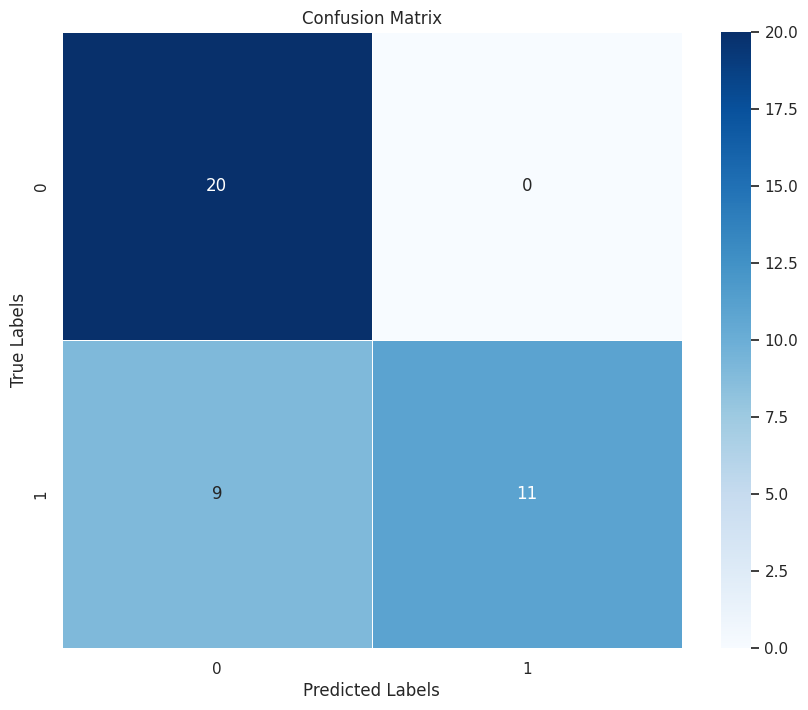

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Set Chinese font
plt.rcParams['font.sans-serif'] = ['SimHei'] 
# assign a list to [中性句、自殺與憂鬱情緒、無助或無望、正向文字、其他負向文字、生理反應或醫療狀況、自殺行為]
# to be axis of heatmap

columns = ['中性句','自殺與憂鬱情緒','無助或無望','正向文字','其他負向文字','生理反應或醫療狀況','自殺行為']



updated_confusion_matrix = [[20, 0],[9, 11]]

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(updated_confusion_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)

# Adding labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
